Loaded logs with 481 data points
Generating comprehensive evaluation plots...
Training progress plot saved to plots/training_progress.png


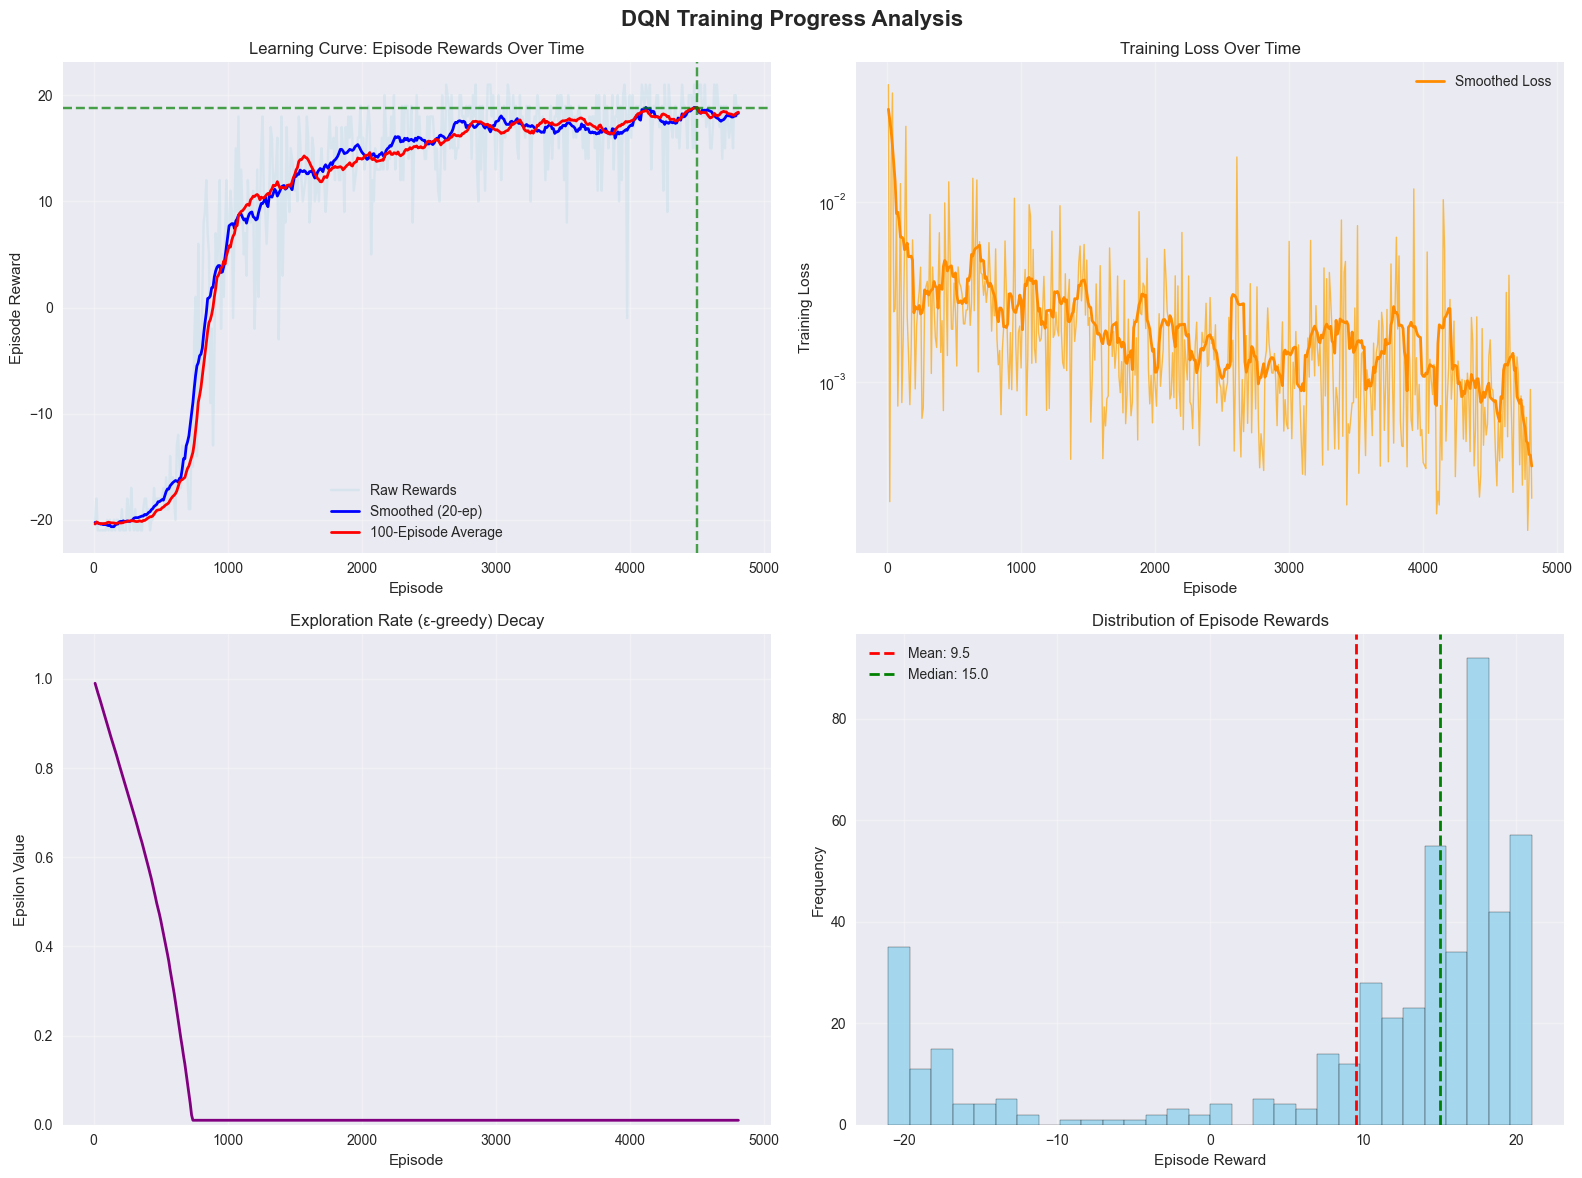

Learning phases plot saved to plots/learning_phases.png


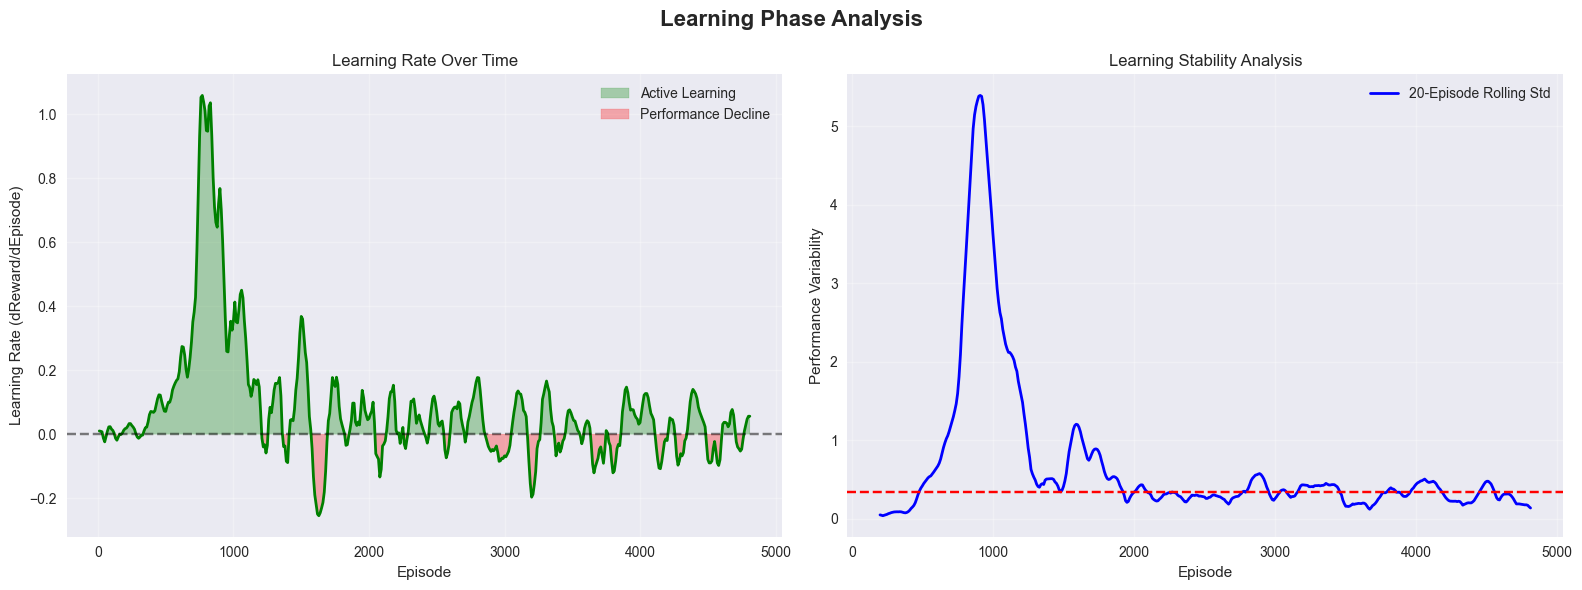

Sample efficiency plot saved to plots/sample_efficiency.png


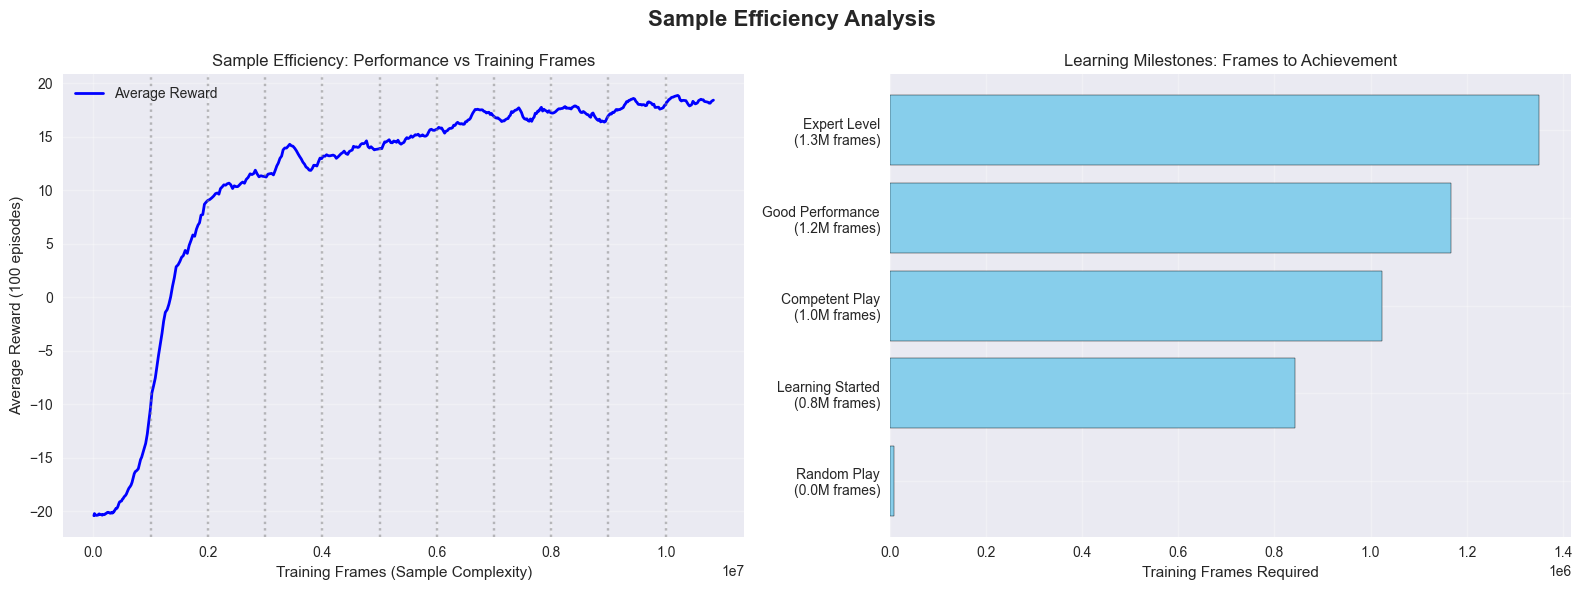

DQN MODEL PERFORMANCE REPORT
Training Episodes: 481
Total Training Frames: 10,833,476 (10.8M)

REWARD STATISTICS:
  Final Average Reward (100-ep): 18.40
  Best Average Reward: 18.84
  Overall Mean Reward: 9.55 ± 13.14
  Median Reward: 15.00
  Reward Range: [-21.0, 21.0]
  Performance Improvement: 38.59 (189.9%)
  Recent Stability (std of last 20): 0.13

LEARNING ANALYSIS:
  Best Learning Period: Episodes 710-910
  Max Improvement in 20 episodes: 9.27

SAMPLE EFFICIENCY MILESTONES:
  Reached -15 reward: 0.8M frames (Episode 710)
  Reached -10 reward: 1.0M frames (Episode 780)
  Reached -5 reward: 1.2M frames (Episode 830)
  Reached +0 reward: 1.3M frames (Episode 890)

All plots saved to plots


In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy import stats

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

class DQNEvaluator:
    def __init__(self, logs_path):
        """Initialize evaluator with path to training logs."""
        self.logs_path = Path(logs_path)
        self.load_training_logs()

    def load_training_logs(self):
        """Load training logs from JSON file."""
        try:
            with open(self.logs_path / "latest_logs.json", 'r') as f:
                self.logs = json.load(f)
            print(f"Loaded logs with {len(self.logs['episodes'])} data points")
        except FileNotFoundError:
            print(f"No logs found at {self.logs_path}")
            self.logs = None

    def smooth_curve(self, data, window_size=10):
        """Apply smoothing to reduce noise in plots."""
        return uniform_filter1d(data, size=window_size, mode='nearest')

    def plot_training_progress(self, save_path=None):
        """Plot comprehensive training progress with multiple subplots."""
        if not self.logs:
            return

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('DQN Training Progress Analysis', fontsize=16, fontweight='bold')

        episodes = np.array(self.logs['episodes'])
        rewards = np.array(self.logs['rewards'])
        avg_rewards = np.array(self.logs['avg_rewards'])
        losses = np.array(self.logs['losses'])
        epsilon = np.array(self.logs['epsilon_values'])

        # 1. Episode Rewards
        axes[0,0].plot(episodes, rewards, alpha=0.3, color='lightblue', label='Raw Rewards')
        axes[0,0].plot(episodes, self.smooth_curve(rewards, 20), color='blue', linewidth=2, label='Smoothed (20-ep)')
        axes[0,0].plot(episodes, avg_rewards, color='red', linewidth=2, label='100-Episode Average')
        axes[0,0].set_xlabel('Episode')
        axes[0,0].set_ylabel('Episode Reward')
        axes[0,0].set_title('Learning Curve: Episode Rewards Over Time')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Add performance milestones
        if len(avg_rewards) > 0:
            best_avg = np.max(avg_rewards)
            best_episode = episodes[np.argmax(avg_rewards)]
            axes[0,0].axhline(y=best_avg, color='green', linestyle='--', alpha=0.7,
                            label=f'Best Avg: {best_avg:.1f}')
            axes[0,0].axvline(x=best_episode, color='green', linestyle='--', alpha=0.7)

        # 2. Training Loss
        axes[0,1].plot(episodes, losses, color='orange', linewidth=1, alpha=0.7)
        axes[0,1].plot(episodes, self.smooth_curve(losses, 10), color='darkorange', linewidth=2, label='Smoothed Loss')
        axes[0,1].set_xlabel('Episode')
        axes[0,1].set_ylabel('Training Loss')
        axes[0,1].set_title('Training Loss Over Time')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_yscale('log')  # Log scale for loss

        # 3. Exploration vs Exploitation
        axes[1,0].plot(episodes, epsilon, color='purple', linewidth=2)
        axes[1,0].set_xlabel('Episode')
        axes[1,0].set_ylabel('Epsilon Value')
        axes[1,0].set_title('Exploration Rate (ε-greedy) Decay')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_ylim(0, 1.1)

        # 4. Performance Distribution
        axes[1,1].hist(rewards, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(np.mean(rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(rewards):.1f}')
        axes[1,1].axvline(np.median(rewards), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(rewards):.1f}')
        axes[1,1].set_xlabel('Episode Reward')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Distribution of Episode Rewards')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Training progress plot saved to {save_path}")
        plt.show()

    def plot_learning_phases(self, save_path=None):
        """Analyze different phases of learning."""
        if not self.logs:
            return

        episodes = np.array(self.logs['episodes'])
        avg_rewards = np.array(self.logs['avg_rewards'])

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Learning Phase Analysis', fontsize=16, fontweight='bold')

        # 1. Learning Rate Analysis
        if len(avg_rewards) > 10:
            # Calculate learning rate (derivative of performance)
            learning_rate = np.gradient(self.smooth_curve(avg_rewards, 5))

            axes[0].plot(episodes, learning_rate, color='green', linewidth=2)
            axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[0].set_xlabel('Episode')
            axes[0].set_ylabel('Learning Rate (dReward/dEpisode)')
            axes[0].set_title('Learning Rate Over Time')
            axes[0].grid(True, alpha=0.3)

            # Identify learning phases
            positive_learning = learning_rate > 0.01
            if np.any(positive_learning):
                axes[0].fill_between(episodes, learning_rate, 0,
                                   where=positive_learning, alpha=0.3, color='green',
                                   label='Active Learning')

            negative_learning = learning_rate < -0.01
            if np.any(negative_learning):
                axes[0].fill_between(episodes, learning_rate, 0,
                                   where=negative_learning, alpha=0.3, color='red',
                                   label='Performance Decline')
            axes[0].legend()

        # 2. Convergence Analysis
        if len(avg_rewards) > 50:
            # Rolling standard deviation to measure stability
            window_size = 20
            rolling_std = pd.Series(avg_rewards).rolling(window_size).std()

            axes[1].plot(episodes[window_size-1:], rolling_std[window_size-1:],
                        color='blue', linewidth=2, label=f'{window_size}-Episode Rolling Std')
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Performance Variability')
            axes[1].set_title('Learning Stability Analysis')
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()

            # Mark convergence point (when variability drops below threshold)
            convergence_threshold = np.mean(rolling_std[window_size:]) * 0.5
            axes[1].axhline(y=convergence_threshold, color='red', linestyle='--',
                          label=f'Convergence Threshold: {convergence_threshold:.2f}')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Learning phases plot saved to {save_path}")
        plt.show()

    def plot_sample_efficiency(self, save_path=None):
        """Analyze sample efficiency using frames instead of episodes."""
        if not self.logs or 'frames' not in self.logs:
            print("Frame data not available for sample efficiency analysis")
            return

        frames = np.array(self.logs['frames'])
        avg_rewards = np.array(self.logs['avg_rewards'])

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Sample Efficiency Analysis', fontsize=16, fontweight='bold')

        # 1. Performance vs Sample Complexity
        axes[0].plot(frames, avg_rewards, color='blue', linewidth=2, label='Average Reward')
        axes[0].set_xlabel('Training Frames (Sample Complexity)')
        axes[0].set_ylabel('Average Reward (100 episodes)')
        axes[0].set_title('Sample Efficiency: Performance vs Training Frames')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()

        # Add million-frame markers
        for million in range(1, int(frames[-1]/1e6) + 1):
            axes[0].axvline(x=million*1e6, color='gray', linestyle=':', alpha=0.5,
                          label=f'{million}M frames' if million == 1 else "")

        # 2. Learning Milestones
        if len(avg_rewards) > 0:
            # Define performance milestones for Pong
            milestones = {
                'Random Play': -21,  # Worst possible in Pong
                'Learning Started': -15,
                'Competent Play': -10,
                'Good Performance': -5,
                'Expert Level': 0
            }

            milestone_frames = []
            milestone_names = []

            for name, threshold in milestones.items():
                # Find first episode where performance exceeded threshold
                exceeded = avg_rewards >= threshold
                if np.any(exceeded):
                    first_idx = np.where(exceeded)[0][0]
                    milestone_frames.append(frames[first_idx])
                    milestone_names.append(f"{name}\n({frames[first_idx]/1e6:.1f}M frames)")

            axes[1].barh(range(len(milestone_frames)), milestone_frames, color='skyblue', edgecolor='black')
            axes[1].set_yticks(range(len(milestone_frames)))
            axes[1].set_yticklabels(milestone_names)
            axes[1].set_xlabel('Training Frames Required')
            axes[1].set_title('Learning Milestones: Frames to Achievement')
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Sample efficiency plot saved to {save_path}")
        plt.show()

    def generate_performance_report(self):
        """Generate a comprehensive text report of model performance."""
        if not self.logs:
            return

        rewards = np.array(self.logs['rewards'])
        avg_rewards = np.array(self.logs['avg_rewards'])
        episodes = np.array(self.logs['episodes'])
        frames = np.array(self.logs['frames']) if 'frames' in self.logs else None

        print("="*60)
        print("DQN MODEL PERFORMANCE REPORT")
        print("="*60)

        print(f"Training Episodes: {len(episodes)}")
        if frames is not None:
            print(f"Total Training Frames: {frames[-1]:,} ({frames[-1]/1e6:.1f}M)")

        print("\nREWARD STATISTICS:")
        print(f"  Final Average Reward (100-ep): {avg_rewards[-1]:.2f}")
        print(f"  Best Average Reward: {np.max(avg_rewards):.2f}")
        print(f"  Overall Mean Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
        print(f"  Median Reward: {np.median(rewards):.2f}")
        print(f"  Reward Range: [{np.min(rewards):.1f}, {np.max(rewards):.1f}]")

        # Performance improvement
        if len(avg_rewards) > 10:
            early_performance = np.mean(avg_rewards[:10])
            late_performance = np.mean(avg_rewards[-10:])
            improvement = late_performance - early_performance
            print(f"  Performance Improvement: {improvement:.2f} ({improvement/abs(early_performance)*100:.1f}%)")

        # Learning stability
        recent_rewards = avg_rewards[-20:] if len(avg_rewards) >= 20 else avg_rewards
        stability = np.std(recent_rewards)
        print(f"  Recent Stability (std of last 20): {stability:.2f}")

        print("\nLEARNING ANALYSIS:")
        if len(avg_rewards) > 50:
            # Find best learning period
            window_size = 20
            improvements = []
            for i in range(len(avg_rewards) - window_size):
                start_avg = np.mean(avg_rewards[i:i+window_size//2])
                end_avg = np.mean(avg_rewards[i+window_size//2:i+window_size])
                improvements.append(end_avg - start_avg)

            best_period_idx = np.argmax(improvements)
            best_improvement = improvements[best_period_idx]
            print(f"  Best Learning Period: Episodes {episodes[best_period_idx]}-{episodes[best_period_idx+window_size]}")
            print(f"  Max Improvement in {window_size} episodes: {best_improvement:.2f}")

        # Sample efficiency milestones
        if frames is not None:
            milestones = [-15, -10, -5, 0]
            print(f"\nSAMPLE EFFICIENCY MILESTONES:")
            for milestone in milestones:
                exceeded = avg_rewards >= milestone
                if np.any(exceeded):
                    first_idx = np.where(exceeded)[0][0]
                    print(f"  Reached {milestone:+.0f} reward: {frames[first_idx]/1e6:.1f}M frames (Episode {episodes[first_idx]})")

        print("="*60)

    def create_all_plots(self, output_dir="./plots"):
        """Generate all evaluation plots and save them."""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        print("Generating comprehensive evaluation plots...")

        # Generate all plots
        self.plot_training_progress(output_path / "training_progress.png")
        self.plot_learning_phases(output_path / "learning_phases.png")
        self.plot_sample_efficiency(output_path / "sample_efficiency.png")

        # Generate performance report
        self.generate_performance_report()

        print(f"\nAll plots saved to {output_path}")

# Usage example
if __name__ == "__main__":
    # Initialize evaluator with path to your logs directory
    # logs_path = "/content/drive/MyDrive/IU/reinforcement_learning/v8/logs"
    logs_path = "."

    evaluator = DQNEvaluator(logs_path)
    evaluator.create_all_plots()